# Building A neural network from scratch
### Gadegbeku Fabio

## Preliminaries


In [105]:
import numpy as np
from sklearn.datasets import make_circles
import matplotlib.pyplot as plt
import copy

### Here we will create a dataset that is not linearly separable. We will use the make_circles function from the sklearn.datasets module.
### Our goal here is to build a feed forward neural network to provide good classification results on this data set

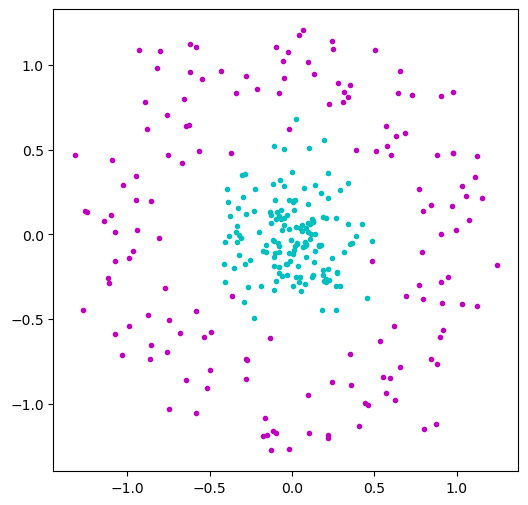

In [106]:
X,y = make_circles(n_samples = 300, noise=0.2, factor=0.1)
n,d = X.shape
plt.figure(1,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.c')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.m')

### The class for the input units

In [107]:
class InputUnit:
    def __init__(self,data):
        self.data = data #one column of matrix X
        self.n = data.shape[0] #dataset size
        self.k = 0 #layer number
        self.z = 0 #unit output
        self.following = []
        self.nfo = 0
        
    # plug following units
    def plug(self,following):
            for elt in following:
                self.following.append(elt)
                self.nfo += 1
                
    # forward pass
    def forward(self,i):
        self.z = self.data[i]
        return self.z

In [108]:
# For example Here we can define our two input units
input1 = InputUnit(X[:,0])
input2 = InputUnit(X[:,1])

### Next we define our neural units which are classical perceptrons

In [109]:
# Our sigmoid activation function
def sigmoid(x):
    res = 1 / (1 + np.exp(-x))
    return res

In [110]:
class NeuralUnit:
    #Constructor
    def __init__(self,k,u):
        self.u = u #unit number
        self.preceding = [] #list of preceding neurons
        self.npr = 0 #length of list preceding
        self.following = [] #list of following neurons
        self.nfo = 0 #length of list following
        self.k = k #layer number
        self.w = 0 #unit weights
        self.b = 0 #unit intercept
        self.z = 0 #unit output
        
    def reset_params(self):
        self.w = np.random.randn(self.npr)
        self.b = np.random.randn()

    def plug(self,preceding,following):
        for elt in preceding:
            self.preceding.append(elt)
            self.npr += 1
        for elt in following:
            self.following.append(elt)
            self.nfo += 1

    def forward(self,i):
        z_in = np.zeros(self.npr)
        for j in range(self.npr):
            z_in[j]= self.preceding[j].forward(i)
        self.z = sigmoid(np.dot(self.w.T,z_in)+self.b)
        return(self.z)
        
    def backprop(self,deltas):
        self.delta = np.zeros(self.w.shape)
        self.w_grad = np.zeros(self.w.shape)
        self.b_grad = 0
        for v,prec_unit in enumerate(self.preceding):
            self.delta[v]= self.z*(1-self.z)*self.w[v]*deltas[self.u]
            self.w_grad[v]= self.z*(1-self.z)*prec_unit.z*deltas[self.u]
            self.b_grad = self.z*(1-self.z)*deltas[self.u]

        
        

### Now the Loss class (log loss)

In [111]:
class Loss:
    #Constructor
    def __init__(self,y,k):
        self.preceding = [] #list of preceding neurons
        self.npr = 0 #length of list preceding
        self.y = y #array of class labels of the training data
        self.k = k #layer index
        self.delta = np.zeros((1,))

    def plug(self,preceding):
        for elt in preceding:
            self.preceding.append(elt)
            self.npr += 1

    def forward(self,i):
        z_in = self.preceding[0].forward(i)
        li = -(1-self.y[i])*np.log(1-z_in) - self.y[i]*np.log(z_in)
        return li
    def backprop(self,i):
        z_in = self.preceding[0].forward(i)
        self.delta[0]=(1-self.y[i])*1/(1-z_in) -y[i]*1/z_in



### And here the final network class that will use and connect the previous classes

In [112]:
class MLP:
#Constructor
    def __init__(self,X,y,archi):
        self.archi = archi
        self.X = X
        self.n = X.shape[0]
        self.y = y
        self.K = len(archi) #number of layers (including input layer and loss layer)
        
        #creating network
        net = []
        for k in range(self.K):
            if k == 0:
                input_units = []
                for i in range(archi[k]):
                    input_unit = InputUnit(X[:,i])
                    input_units.append(input_unit)
                net.append(input_units)
            elif k == self.K-1:
                    loss = Loss(y,k)
                    net.append([loss])
            else:
                neural_units = []
                for i in range(archi[k]):
                    neural_unit = NeuralUnit(k,i)
                    neural_units.append(neural_unit)
                net.append(neural_units)

        #plugging units
        for k in range(self.K):
            if k == 0:
                for input_unit in net[k]:
                    input_unit.plug(net[k+1])
            elif k == self.K-1:
                for loss in net[k]:
                    loss.plug(net[k-1])
            else:
                for neural_unit in net[k]:
                    neural_unit.plug(net[k-1],net[k+1])
                    neural_unit.reset_params()

        self.net = net

    def forward(self,i):
        res = self.net[self.K-1][0].forward(i)
        return res
    
    def backprop(self,i):
        for k in range(self.K-1,0,-1):
            if k == self.K-1:
                self.net[k][0].backprop(i)
                deltas = self.net[k][0].delta
            else:
                deltas_new = np.zeros((self.net[k][0].npr,))
                for u in range(len(self.net[k])):
                    self.net[k][u].backprop(deltas)
                    deltas_new+=self.net[k][u].delta
                deltas = deltas_new
    #Training the network with 'stochastic' gradient descent
    def train(self, epochs,eta):
        for epoch in range(epochs):
            for i in range(self.n):
                self.forward(i)
                self.backprop(i)
                self.update(eta)

    def predict(self,i):
        res = self.net[self.K-2][0].forward(i)
        return res
    
    def update(self,eta):
        for k in range(1,self.K-1):
            for neural_unit in self.net[k]:
                neural_unit.w -= eta*neural_unit.w_grad
                neural_unit.b -= eta*neural_unit.b_grad
        

        




            

        

In [113]:
# We can easily define an architecture of our network 'The first coordinate are input classes (n_input)
# The last coordinate is loss layor (always 1 in our case)
# The other coordinates are hidden layers
mlp = MLP(X,y,[2,2,1,1])
print('The network is composed of',mlp.K -1,'layers')
print('The full network is :',mlp.net)
print('The followings of the first input unit of first layer are :',mlp.net[0][0].following)
print('The followings of first neural unit of first layer are :',mlp.net[1][0].following)
print('The precedings of the first neural unit of the first layer are:',mlp.net[1][0].preceding)
print('The precedings of loss layer are:',mlp.net[3][0].preceding)  
print('random weights of first neural unit of first layer are:',mlp.net[1][0].w,mlp.net[1][0].b)

The network is composed of 3 layers
The full network is : [[<__main__.InputUnit object at 0x169c87c10>, <__main__.InputUnit object at 0x169c85410>], [<__main__.NeuralUnit object at 0x169c85ed0>, <__main__.NeuralUnit object at 0x169cae2d0>], [<__main__.NeuralUnit object at 0x169c87390>], [<__main__.Loss object at 0x169c85a10>]]
The followings of the first input unit of first layer are : [<__main__.NeuralUnit object at 0x169c85ed0>, <__main__.NeuralUnit object at 0x169cae2d0>]
The followings of first neural unit of first layer are : [<__main__.NeuralUnit object at 0x169c87390>]
The precedings of the first neural unit of the first layer are: [<__main__.InputUnit object at 0x169c87c10>, <__main__.InputUnit object at 0x169c85410>]
The precedings of loss layer are: [<__main__.NeuralUnit object at 0x169c87390>]
random weights of first neural unit of first layer are: [-1.15598324  2.13465944] 0.14119860339004547


We dont get very good results, our architecture is not complex enough lets try to increase the number of neurons in the first hidden layers


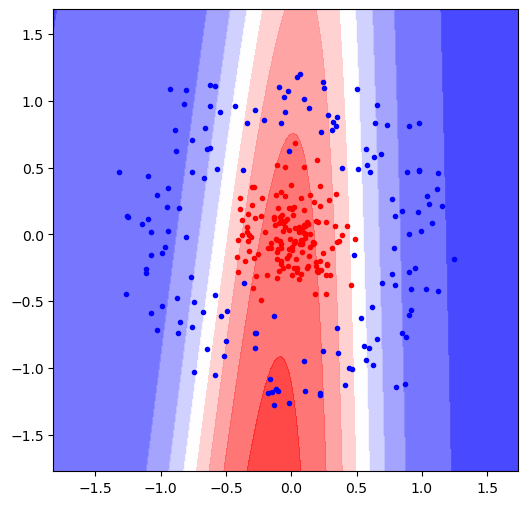

In [114]:
mlp2 = MLP(X,y,[2,2,1,1]) # Here we have   hidden layers with 2 neurons lets train it 
mlp2.train(100,0.01)

# Now we can plot the decision boundary
h = .02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),
                        np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z = []
for u in range(mlp2.archi[0]):
    mlp2.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp2.predict(i))
for u in range(mlp.archi[0]):
    mlp2.net[0][u].data = X[:,u]
Z = np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(2,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)
print('We dont get very good results, our architecture is not complex enough lets try to increase the number of neurons in the first hidden layers')

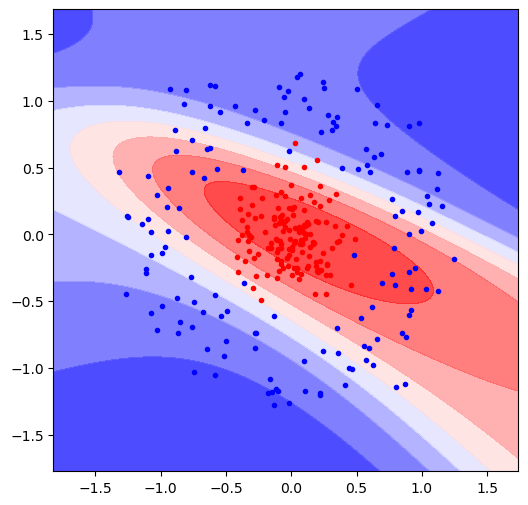

In [115]:
mlp4 = MLP(X,y,[2,4,1,1]) # Here we have   hidden layers with 4 neurons lets train it and plot the results
mlp4.train(100,0.01)
h = .02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),
                        np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z = []
for u in range(mlp4.archi[0]):
    mlp4.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp4.predict(i))
for u in range(mlp4.archi[0]):
    mlp4.net[0][u].data = X[:,u]
Z = np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(2,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)

We get better results with 10 neurons in the first hidden layer
Adding a neuron in the second hidden layer seeems to give the model the ability to learn a new decision line


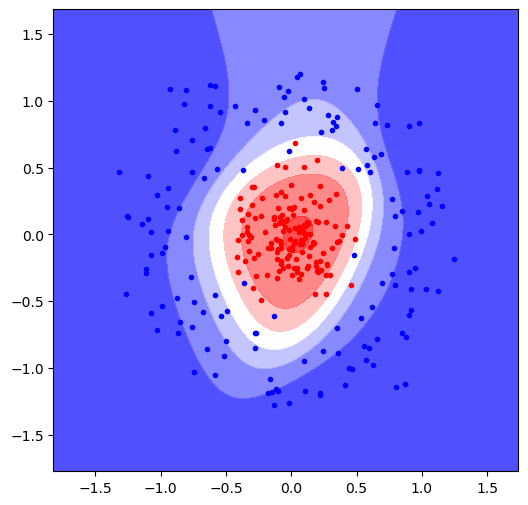

In [117]:
mlp10 = MLP(X,y,[2,10,1,1]) # Here we have   hidden layers with 10 neurons lets train it and plot the results
mlp10.train(100,0.01)

h = .02
x1_min, x1_max = X[:, 0].min() - .5, X[:, 0].max() + .5
x2_min, x2_max = X[:, 1].min() - .5, X[:, 1].max() + .5
x11, x22 = np.meshgrid(np.arange(x1_min, x1_max, h),
                        np.arange(x2_min, x2_max, h))
X_disp = np.c_[x11.ravel(), x22.ravel()]
n_disp = X_disp.shape[0]
Z = []
for u in range(mlp10.archi[0]):
    mlp10.net[0][u].data = X_disp[:,u]
for i in range(n_disp):
    Z.append(mlp10.predict(i))
for u in range(mlp10.archi[0]):
    mlp10.net[0][u].data = X[:,u]
Z = np.array(Z)
Z = Z.reshape(x11.shape)
plt.figure(3,figsize=[6,6])
plt.plot(X[:,0][np.where(y==1)],X[:,1][np.where(y==1)],'.r')
plt.plot(X[:,0][np.where(y==0)],X[:,1][np.where(y==0)],'.b')
plt.contourf(x11, x22, Z, cmap=plt.cm.bwr, alpha=.8)
print('We get better results with 10 neurons in the first hidden layer')
print('Adding a neuron in the second hidden layer seeems to give the model the ability to learn a new decision line')
